# Polynomial Regression

This example has been contributed by Tyler James Burch ([\@tjburch](https://github.com/tjburch) on GitHub).

In [1]:
import arviz as az
import bambi as bmb
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


plt.style.use("arviz-darkgrid")
SEED = 1234
np.random.seed(SEED)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


This example will discuss polynomial regression using Bambi. Unlike many other examples shown, there aren't specific polynomial methods or families implemented in Bambi, most of the interesting behavior for polynomial regression occurs within the formula definition. Regardless, there are some nuances that are useful to be aware of. 

This example uses the kinematic equations from classical mechanics as a backdrop. Specifically, an object in motion experiencing constant acceleration can be described by the following:

$$x_f = \frac{1}{2} a t^2 + v_0 t + x_0$$

Where $x_0$ and $x_f$ are the initial and final locations, $v_0$ is the initial velocity, and $a$ is acceleration.

## A falling ball

First, we'll consider a simple falling ball, released from 50 meters. In this situation, $v_0 = 0$ $m$/$s$, $x_0 = 50$ $m$ and $a = g$, the acceleration due to gravity, $-9.81$ $m$/$s^2$. So dropping out the $v_0 t$ component, the equation takes the form:

$$x_f = \frac{1}{2} g t^2 + x_0$$

We'll start by simulating data for the first 2 seconds of motion. We will also assume some measurement error with a gaussian distribution of $\sigma = 0.3$.

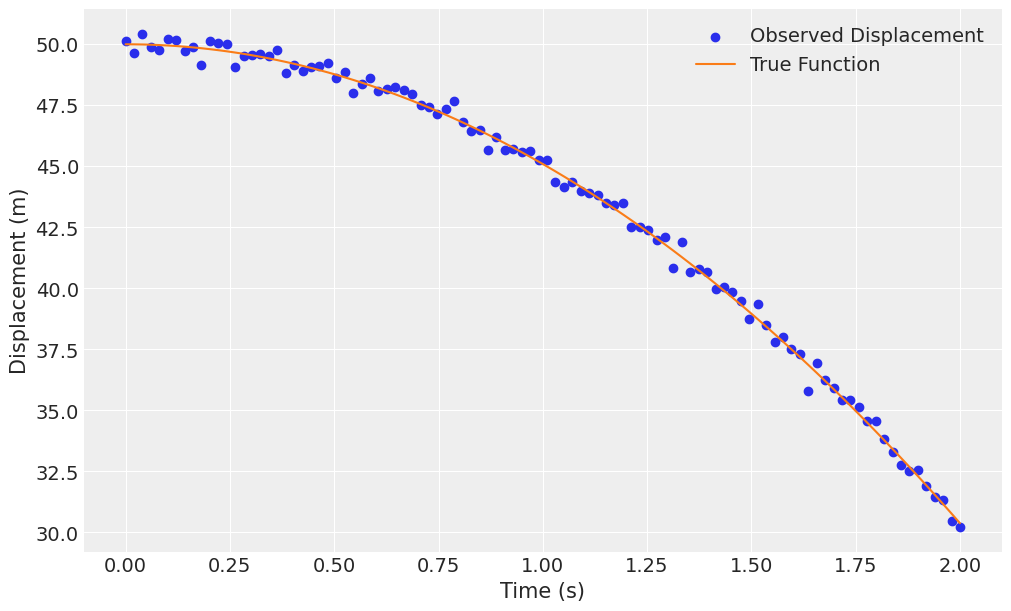

In [2]:
g = -9.81  # acceleration due to gravity (m/s^2)
t = np.linspace(0, 2, 100)  # time in seconds
inital_height = 50
x_falling = 0.5 * g * t**2 + inital_height
noise = np.random.normal(0, 0.3, x_falling.shape)
x_obs_falling = x_falling + noise
df_falling = pd.DataFrame({'t': t, 'x': x_obs_falling})

plt.figure(figsize=(10, 6))
plt.scatter(t, x_obs_falling, label='Observed Displacement', color="C0")
plt.plot(t, x_falling, label='True Function', color="C1")
plt.xlabel('Time (s)')
plt.ylabel('Displacement (m)')
plt.legend()
plt.show()

Casting the equation $x_f = \frac{1}{2} g t^2 + x_0$ into a regression context, we let time ($t$) be the independent variable, and final location ($x_f$) be the response/dependent variable. This allows our coefficients to be proportional to $g$ and $x_0$. The intercept, $\beta_0$ corresponds exactly to $x_0$. Letting $\beta_1 = \frac{1}{2} g$ then gives $g = 2\beta_1$ when $x_1 = t^2$, meaning we're doing _polynomial regression_. We can put this into Bambi via the following, optionally including the `+ 1` to emphasize that we choose to include the coefficient. 

In [3]:
model_falling = bmb.Model("x ~ I(t**2) + 1", df_falling)
results_falling = model_falling.fit(idata_kwargs={"log_likelihood": True}, random_seed=SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x_sigma, Intercept, I(t ** 2)]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


The term `I(t**2)` indicates to evaluate inside the `I`. For including _just the $t^2$ term_, you can express it any of the following ways:  

- `I(t**2)`
- `{t**2}`
- Square the data directly, and pass it as a new column

To verify, we'll fit the other two versions as well.

In [4]:
model_falling_variation1 = bmb.Model(
    "x ~ {t**2} + 1",  # Using {t**2} syntax
    df_falling
)
results_variation1 = model_falling_variation1.fit(random_seed=SEED)

model_falling_variation2 = bmb.Model(
    "x ~ tsquared + 1",  # Using data with the t variable squared
    df_falling.assign(tsquared=t**2)  # Creating the tsquared variable for use in the formula
)
results_variation2 = model_falling_variation2.fit(random_seed=SEED)

print("I{t**2} coefficient: ", round(results_falling.posterior["I(t ** 2)"].values.mean(), 4))
print("{t**2} coefficient: ", round(results_variation1.posterior["I(t ** 2)"].values.mean(), 4))
print("tsquared coefficient: ", round(results_variation2.posterior["tsquared"].values.mean(), 4))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x_sigma, Intercept, I(t ** 2)]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x_sigma, Intercept, tsquared]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


I{t**2} coefficient:  -4.9123
{t**2} coefficient:  -4.9123
tsquared coefficient:  -4.9123


Each of these provides identical results, giving -4.9, which is $g/2$. This makes the acceleration exactly the $-9.81$ $m$/$s^2$ acceleration that generated the data. Looking at our model summary,

In [5]:
az.summary(results_falling)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,50.020,0.045,49.931,50.101,0.001,0.0,6578.0,3266.0,1.0
I(t ** 2),-4.912,0.025,-4.958,-4.863,0.000,0.0,6465.0,2938.0,1.0
x_sigma,0.305,0.022,0.264,0.348,0.000,0.0,5970.0,3054.0,1.0


We see that both $g/2 = -4.9$ (so $g=-9.81$) and the original height of $x_0 = 50$ $m$ are recovered, along with the injected noise.

We can then use the model to answer some questions, for example would the ball land? This would correspond to $x_f = 0$.

$$0 = \frac{1}{2} g t^2 - x_0$$

$$t = \sqrt{2x_0 / g}$$

In [6]:
calculated_x0 = results_falling.posterior["Intercept"].values.mean()
calculated_g = -2 * results_falling.posterior["I(t ** 2)"].values.mean()
calculated_land = np.sqrt(2 * calculated_x0 / calculated_g)
print(f"The ball will land at {round(calculated_land, 2)} seconds")

The ball will land at 3.19 seconds


Or if we want to account for our measurement error and use the full posterior,

In [7]:
calculated_x0_posterior = results_falling.posterior["Intercept"].values
calculated_g_posterior = -2 * results_falling.posterior["I(t ** 2)"].values
calculated_land_posterior = np.sqrt(2 * calculated_x0_posterior / calculated_g_posterior)
lower_est = round(np.quantile(calculated_land_posterior, 0.025), 2)  
upper_est = round(np.quantile(calculated_land_posterior, 0.975), 2)
print(f"The ball landing will be measured between {lower_est} and {upper_est} seconds")

The ball landing will be measured between 3.18 and 3.21 seconds


## Projectile Motion

Next, instead of a ball strictly falling, instead imagine one thrown straight upward. In this case, we add the initial velocity back into the equation.

$$x_f = \frac{1}{2} g t^2 + v_0 t + x_0$$

We will envision the ball tossed upward, starting at 1.5 meters above ground level. It will be tossed at 7 m/s upward. It will also stop when hitting the ground.


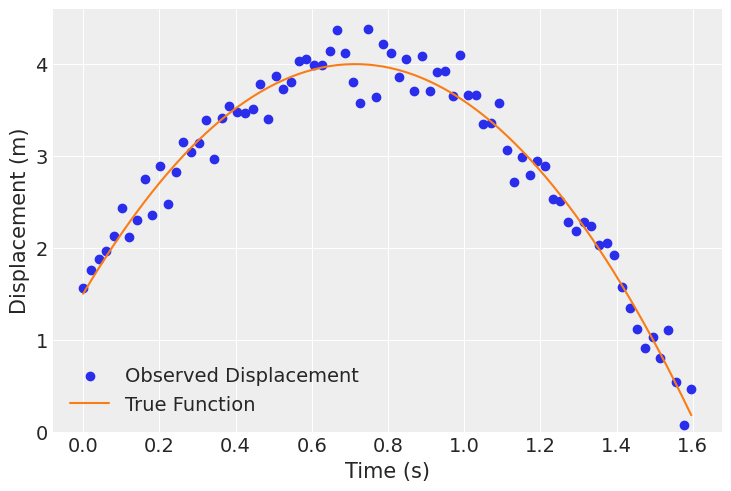

In [8]:
v0 = 7
x0 = 1.5
x_projectile = (1/2) * g * t**2 + v0 * t + x0
noise = np.random.normal(0, 0.2, x_projectile.shape)
x_obs_projectile = x_projectile + noise
df_projectile = pd.DataFrame({"t": t, "tsq": t**2, "x": x_obs_projectile, "x_true": x_projectile})
df_projectile = df_projectile[df_projectile["x"] >= 0]


plt.scatter(df_projectile.t, df_projectile.x, label='Observed Displacement', color="C0")
plt.plot(df_projectile.t, df_projectile.x_true, label='True Function', color="C1")
plt.xlabel('Time (s)')
plt.ylabel('Displacement (m)')
plt.ylim(bottom=0)
plt.legend()
plt.show()

Modeling this using Bambi, we must include the linear term on time to capture the inital velocity. We'll do the following regression,

$$x_f = \beta_0 + \beta_1 t + \beta_2 t^2$$

Which then maps the solved coefficents to the following: $\beta_0 = x_0$, $\beta_1 = v_0$, and $\beta_2 = \frac{g}{2}$.

In [9]:
model_projectile_all_terms = bmb.Model("x ~ I(t**2) + t + 1", df_projectile)
fit_projectile_all_terms = model_projectile_all_terms.fit(idata_kwargs={"log_likelihood": True}, target_accept=0.9, random_seed=SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x_sigma, Intercept, I(t ** 2), t]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [10]:
az.summary(fit_projectile_all_terms)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.518,0.066,1.400,1.646,0.001,0.001,2048.0,2199.0,1.0
I(t ** 2),-4.890,0.115,-5.106,-4.680,0.003,0.002,1732.0,1951.0,1.0
t,6.975,0.191,6.637,7.340,0.005,0.003,1697.0,1747.0,1.0
x_sigma,0.200,0.017,0.170,0.231,0.000,0.000,2415.0,2065.0,1.0


In [11]:
hdi = az.hdi(fit_projectile_all_terms.posterior, hdi_prob=0.95)
print(f"Initial height: {hdi['Intercept'].sel(hdi='lower'):.2f} to {hdi['Intercept'].sel(hdi='higher'):.2f} meters (True: {x0} m)")
print(f"Initial velocity: {hdi['t'].sel(hdi='lower'):.2f} to {hdi['t'].sel(hdi='higher'):.2f} meters per second (True: {v0} m/s)")
print(f"Acceleration: {2*hdi['I(t ** 2)'].sel(hdi='lower'):.2f} to {2*hdi['I(t ** 2)'].sel(hdi='higher'):.2f} meters per second squared (True: {g} m/s^2)")

Initial height: 1.39 to 1.65 meters (True: 1.5 m)
Initial velocity: 6.61 to 7.34 meters per second (True: 7 m/s)
Acceleration: -10.21 to -9.33 meters per second squared (True: -9.81 m/s^2)


We once again are able to recover all our input parameters.

In addition to directly calculating all terms, to include all polynomial terms up to a given degree you can use the `poly` keyword. We don't do that in this notebook for two reasons. First, by default it orthogonalizes the terms making it ill-suited to this example since the coefficients have physical meaning. For more information on the orthogonalization, please see the [orthogonal polynomial notebook](https://bambinos.github.io/bambi/notebooks/orthogonal_polynomial_reg.html). The orthogonalization process can be disabled by the `raw` argument of `poly`, but we still elect not to use it because in later examples we decide to use different effects on the $t$ term vs the $t^2$ term, and doing so is not easy when using `poly`. However, just to show that the results match when using the `raw = True` argument, we'll fit the same model as above.

In [12]:
model_poly_raw = bmb.Model("x ~ poly(t, 2, raw=True)", df_projectile)
fit_poly_raw = model_poly_raw.fit(idata_kwargs={"log_likelihood": True}, random_seed=SEED)
az.summary(fit_poly_raw)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x_sigma, Intercept, poly(t, 2, raw=True)]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.515,0.066,1.385,1.633,0.001,0.001,2135.0,2073.0,1.0
"poly(t, 2, raw=True)[0]",6.981,0.188,6.656,7.355,0.005,0.003,1670.0,1726.0,1.0
"poly(t, 2, raw=True)[1]",-4.893,0.115,-5.119,-4.697,0.003,0.002,1598.0,1631.0,1.0
x_sigma,0.200,0.016,0.171,0.232,0.000,0.000,2881.0,2436.0,1.0


We see the same results, where `poly(t, 2, raw=True)[0]` corresponds to the coefficient on $t$ ($v_0$ in our example), and `poly(t, 2, raw=True)[1]` is the coefficient on $t^2$ ($\frac{g}{2}$).

## Measuring gravity on a new planet

In the next example, you've been recruited to join the space program as a research scientist, looking to directly measure the gravity on a new planet, PlanetX. You don't know anything about this planet or it's safety, so you have time for one, and only one, throw of a ball. However, you've perfected your throwing mechanics, and can achieve the same initial velocity wherever you are. To baseline, you make a toss on planet Earth, warm up your spacecraft and stop at Mars to make a toss, then travel far away, and make a toss on PlanetX. 

First we simulate data for this experiment.

In [13]:
def simulate_throw(v0, g, noise_std, time_step=0.25, max_time=10):
    times = np.arange(0, max_time, time_step)
    heights = v0 * times - 0.5 * g * times**2
    heights_with_noise = heights + np.random.normal(0, noise_std, len(times))    
    valid_indices = heights_with_noise >= 0
    return times[valid_indices], heights_with_noise[valid_indices], heights[valid_indices]

# Define the parameters
v0 = 20  # Initial velocity (m/s)
g_planets = {'Earth': 9.81, "Mars": 3.72, 'PlanetX': 6.0}  # Gravitational acceleration (m/s^2)
noise_std = 1.5  # Standard deviation for noise

# Generate data
records = []
for planet, g in g_planets.items():
    times, heights, heights_true = simulate_throw(v0, g, noise_std)
    for time, height, height_true in zip(times, heights, heights_true):
        records.append([planet, time, height, height_true])

# Convert to a DataFrame
df = pd.DataFrame(records, columns=['Planet', 'Time', 'Height', 'Height_true'])
df["Planet"] = df["Planet"].astype('category')

And drawing those trajectories,

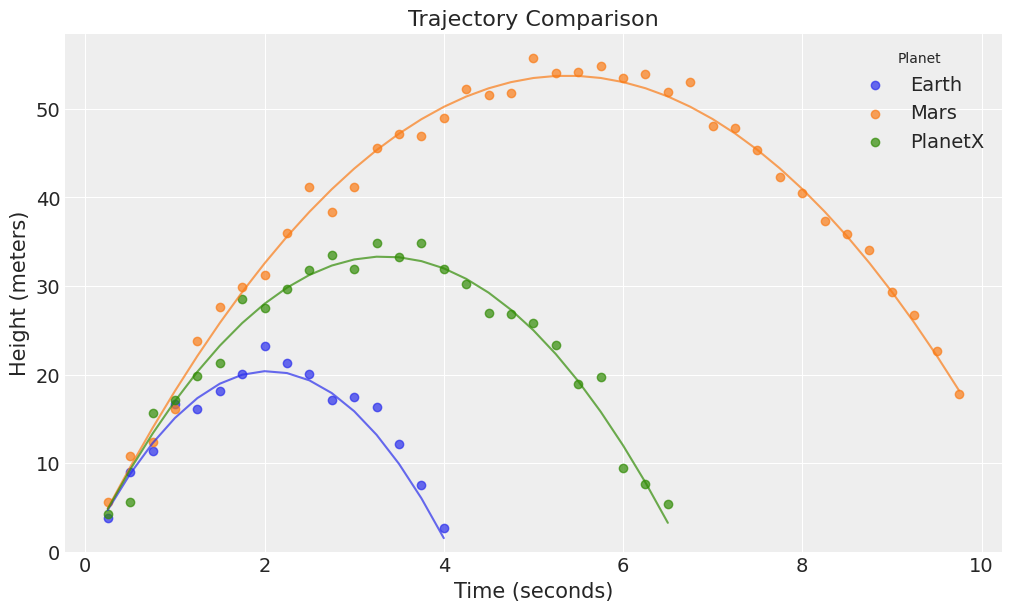

In [14]:
plt.figure(figsize=(10, 6))
for i, planet in enumerate(df['Planet'].cat.categories):
    subset = df[df['Planet'] == planet]
    plt.plot(subset['Time'], subset['Height_true'], alpha=0.7, color=f'C{i}')
    plt.scatter(subset['Time'], subset['Height'], alpha=0.7, label=planet, color=f'C{i}')
plt.legend(title='Planet')
plt.title('Trajectory Comparison')
plt.xlabel('Time (seconds)')
plt.ylabel('Height (meters)')
plt.ylim(bottom=0);

We now aim to model this data. We again use the folowing equation (calling displacement $h$ for height):

$$
h = \frac{1}{2} g_{p} t^2 + v_{0} t
$$

where $g_p$ now has a subscript to indicate the planet that we're throwing from.

In Bambi, we'll do the following:

`Height ~ I(Time**2):Planet + Time + 0`

which corresponds one-to-one with the above formula. The intercept is eliminated since we start from $x=0$. We will use random effects in this case for our planets.

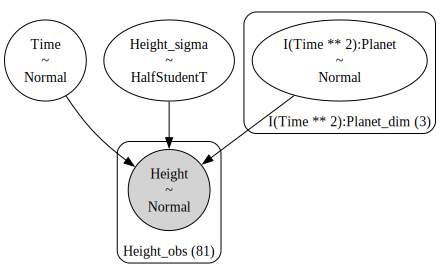

In [15]:
planet_model = bmb.Model('Height  ~ I(Time**2):Planet + Time + 0', df)
planet_model.build()
planet_model.graph()

In [16]:
planet_fit = planet_model.fit(idata_kwargs={"log_likelihood": True}, random_seed=SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Height_sigma, I(Time ** 2):Planet, Time]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


The model has fit. Let's look at how we did recovering the simulated parameters.

In [18]:
az.summary(planet_fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
I(Time ** 2):Planet[Earth],-4.773,0.063,-4.899,-4.660,0.002,0.001,1720.0,1971.0,1.0
I(Time ** 2):Planet[Mars],-1.857,0.018,-1.889,-1.822,0.001,0.000,1245.0,1566.0,1.0
I(Time ** 2):Planet[PlanetX],-2.988,0.030,-3.040,-2.932,0.001,0.001,1300.0,1825.0,1.0
Time,20.009,0.138,19.757,20.267,0.004,0.003,1231.0,1527.0,1.0
Height_sigma,1.472,0.125,1.256,1.719,0.003,0.002,1631.0,1289.0,1.0


Getting the gravities back to the physical value,

In [19]:
hdi = az.hdi(planet_fit.posterior, hdi_prob=0.95)
print(f"g for Earth: {2*hdi['I(Time ** 2):Planet'].sel({'I(Time ** 2):Planet_dim':'Earth', 'hdi':'lower'}):.2f} to {2*hdi['I(Time ** 2):Planet'].sel({'I(Time ** 2):Planet_dim':'Earth', 'hdi':'higher'}):.2f} meters (True: -9.81 m)")
print(f"g for Mars: {2*hdi['I(Time ** 2):Planet'].sel({'I(Time ** 2):Planet_dim':'Mars', 'hdi':'lower'}):.2f} to {2*hdi['I(Time ** 2):Planet'].sel({'I(Time ** 2):Planet_dim':'Mars', 'hdi':'higher'}):.2f} meters (True: -3.72 m)")
print(f"g for PlanetX: {2*hdi['I(Time ** 2):Planet'].sel({'I(Time ** 2):Planet_dim':'PlanetX', 'hdi':'lower'}):.2f} to {2*hdi['I(Time ** 2):Planet'].sel({'I(Time ** 2):Planet_dim':'PlanetX', 'hdi':'higher'}):.2f} meters (True: -6.0 m)")
print(f"Initial velocity: {hdi['Time'].sel(hdi='lower'):.2f} to {hdi['Time'].sel(hdi='higher'):.2f} meters per second (True: 20 m/s)")


g for Earth: -9.80 to -9.30 meters (True: -9.81 m)
g for Mars: -3.78 to -3.64 meters (True: -3.72 m)
g for PlanetX: -6.09 to -5.86 meters (True: -6.0 m)
Initial velocity: 19.74 to 20.27 meters per second (True: 20 m/s)


We can see that we're pretty close to recovering most the parameters, but the fit isn't great. Plotting the posteriors for $g$ agsint the true values,

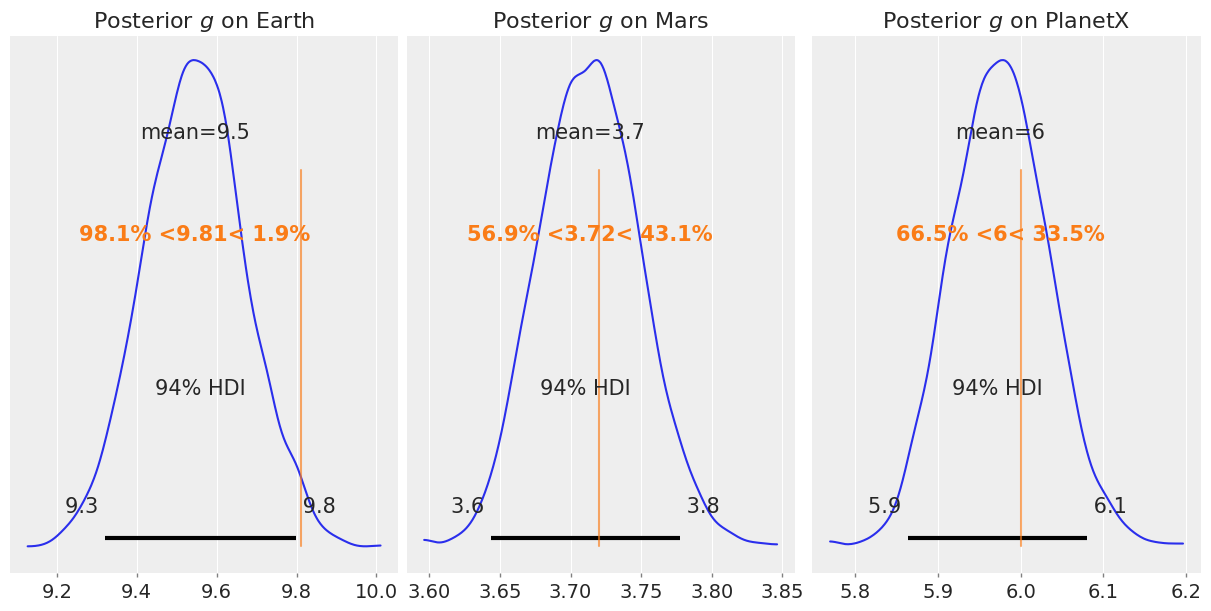

In [20]:
earth_posterior = -2 * planet_fit.posterior["I(Time ** 2):Planet"].sel({"I(Time ** 2):Planet_dim": "Earth"})
planetx_posterior = -2 * planet_fit.posterior["I(Time ** 2):Planet"].sel({"I(Time ** 2):Planet_dim": "PlanetX"})
mars_posterior = -2 * planet_fit.posterior["I(Time ** 2):Planet"].sel({"I(Time ** 2):Planet_dim": "Mars"}) 

fig, axs = plt.subplots(1, 3, figsize=(12, 6))
az.plot_posterior(earth_posterior, ref_val=9.81, ax=axs[0])
axs[0].set_title("Posterior $g$ on Earth")
az.plot_posterior(mars_posterior, ref_val=3.72, ax=axs[1])
axs[1].set_title("Posterior $g$ on Mars")
az.plot_posterior(planetx_posterior, ref_val=6.0, ax=axs[2])
axs[2].set_title("Posterior $g$ on PlanetX");

The fit seems to work, more or less, but certainly could be improved.

### Adding a prior

But, we can do better! We have a [very good idea of the acceleration due to gravity on Earth](https://en.wikipedia.org/wiki/Gravity_of_Earth) and [Mars](https://en.wikipedia.org/wiki/Gravity_of_Mars), so why not use that information? From an experimental standpoint, we can consider these throws from a calibration mindset, allowing us to get some information on the resolution of our detector, and our throwing apparatus. The model will spend considerably less time trying pin down those parameters, and will better explore other parameters with already good values of the $g$ terms locked in.

For Earth, at the extremes, $g$ takes values as low as 9.78 $m$/$s^2$ (at the Equator) up to 9.83 (at the Poles). So we can add a very strong prior,

$$
g_{\text{Earth}} \sim \text{Normal}(-9.81, 0.025)
$$

For Mars, we know the mean value is about 3.72 $m$/$s^2$. There's less information on local variation readily available by a cursory search, _however_ we know that the radius of Mars is about half that of Earth, so $\sigma = \frac{0.025}{2} = 0.0125$ might make sense, but to be conservative we'll round that up to $\sigma = 0.02$.

$$
g_{\text{Mars}} \sim \text{Normal}(-3.72, 0.02)
$$

For PlanetX, we must use a very loose prior. We might say that we know the ball took longer to fall than Earth, but not as long as on Mars, so we can split the difference. Then set a very wide $\sigma$ value.

$$
g_{\text{PlanetX}} \sim \text{Normal}(\frac{-9.81 - 3.72}{2}, 3) = \text{Normal}(-6.77, 3)
$$

Since these correspond to $g/2$, we'll divide all values by 2 when putting them into Bambi. Additionally, we know the balls landed eventually, so $g$ _must be_ negative. We'll truncate the upper limit of the distribution at 0.

Now, for defining this in Bambi, the term of interest is `I(Time ** 2):Planet`. Often, you set one prior that applies to all groups, however, if you want to set each group individually, you can pass a list to the `bmb.Prior` definition. [The broadcasting rules from PyMC apply here](https://github.com/bambinos/bambi/issues/778), so it could equivalently take a numpy array. You'll notice that the priors are passed alphabetically by group name.

In [21]:

priors = {
    "I(Time ** 2):Planet": bmb.Prior(
        'TruncatedNormal',
        mu=[
            -9.81/2,  # Earth
            -3.72/2,  # Mars
            -6.77/2    # PlanetX
        ],
        sigma=[ 
            0.025/2,  # Earth 
            0.02/2,   # Mars
            3/2       # PlanetX
        ],
        upper=[0, 0, 0]
    )} 

planet_model_with_prior = bmb.Model(
    'Height ~ I(Time**2):Planet + Time + 0',
    df,
    priors=priors
)

planet_model_with_prior.build()
idata = planet_model_with_prior.prior_predictive()
az.summary(idata.prior, kind="stats")

Sampling: [Height, Height_sigma, I(Time ** 2):Planet, Time]


,mean,sd,hdi_3%,hdi_97%
Time,-0.037,14.783,-27.537,25.227
I(Time ** 2):Planet[Earth],-4.905,0.012,-4.927,-4.881
I(Time ** 2):Planet[Mars],-1.861,0.010,-1.878,-1.843
I(Time ** 2):Planet[PlanetX],-3.534,1.435,-6.044,-0.836
Height_sigma,15.296,15.193,0.032,36.874


Here we've sampled the prior predictive and can see that our priors are correctly specified to the associated planets.

Next we fit the model.

In [22]:
planet_fit_with_prior = planet_model_with_prior.fit(idata_kwargs={"log_likelihood": True}, random_seed=SEED)
az.summary(planet_fit_with_prior)
planet_model_with_prior.predict(planet_fit_with_prior, kind="pps");

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Height_sigma, I(Time ** 2):Planet, Time]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [23]:
az.summary(planet_fit_with_prior)[0:5]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Time,20.101,0.070,19.975,20.240,0.002,0.001,2051.0,2199.0,1.0
Height_sigma,1.501,0.122,1.272,1.728,0.002,0.002,3688.0,2731.0,1.0
I(Time ** 2):Planet[Earth],-4.898,0.012,-4.921,-4.874,0.000,0.000,3531.0,2470.0,1.0
I(Time ** 2):Planet[Mars],-1.867,0.008,-1.883,-1.851,0.000,0.000,2279.0,2408.0,1.0
I(Time ** 2):Planet[PlanetX],-3.005,0.020,-3.042,-2.967,0.000,0.000,2170.0,2541.0,1.0


We see some improvements here! Off the cuff, these look better, you'll notice the $v_0$ coefficient on `Time` covers the true value of 20 m/s.

Now taking a look at the effects before and after adding the prior on the gravities,

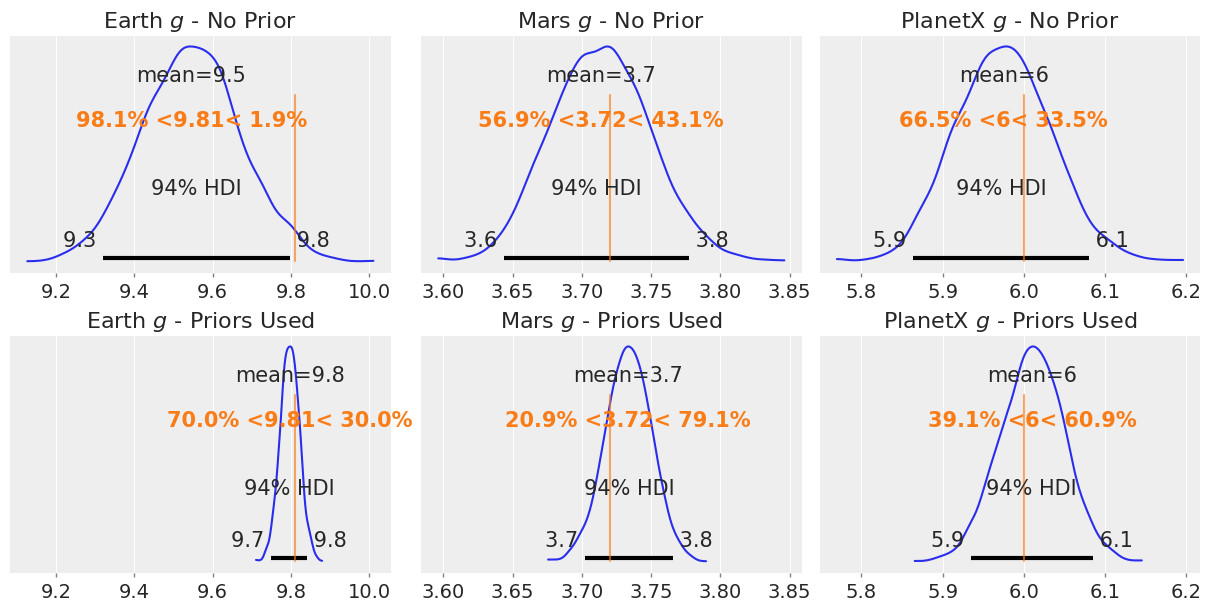

In [24]:
earth_posterior_2 = -2 *  planet_fit_with_prior.posterior["I(Time ** 2):Planet"].sel({"I(Time ** 2):Planet_dim": "Earth"})
mars_posterior_2 = -2 * planet_fit_with_prior.posterior["I(Time ** 2):Planet"].sel({"I(Time ** 2):Planet_dim": "Mars"})
planetx_posterior_2 = -2 * planet_fit_with_prior.posterior["I(Time ** 2):Planet"].sel({"I(Time ** 2):Planet_dim": "PlanetX"})

fig, axs = plt.subplots(2, 3, figsize=(12, 6), sharex='col')
az.plot_posterior(earth_posterior, ref_val=9.81, ax=axs[0,0])
axs[0,0].set_title("Earth $g$ - No Prior")
az.plot_posterior(mars_posterior, ref_val=3.72, ax=axs[0,1])
axs[0,1].set_title("Mars $g$ - No Prior")
az.plot_posterior(planetx_posterior, ref_val=6.0, ax=axs[0,2])
axs[0,2].set_title("PlanetX $g$ - No Prior")


az.plot_posterior(earth_posterior_2, ref_val=9.81, ax=axs[1,0])
axs[1,0].set_title("Earth $g$ - Priors Used")
az.plot_posterior(mars_posterior_2, ref_val=3.72, ax=axs[1,1])
axs[1,1].set_title("Mars $g$ - Priors Used")
az.plot_posterior(planetx_posterior_2, ref_val=6.0, ax=axs[1,2])
axs[1,2].set_title("PlanetX $g$ - Priors Used");


Adding the prior gives smaller uncertainties for Earth and Mars by design, however, we can see the estimate for PlanetX has also considerably improved by injecting our knowledge into the model.